In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

In [4]:
#training dataframe
train_list = [file for file in os.listdir(train_dir)]
df_train = pd.DataFrame({'image': train_list})

#test dataframe
test_list = [file for file in os.listdir(test_dir)]
df_test = pd.DataFrame({'image': test_list})

In [5]:
def label(x):
    fingers = x.str.split('_', expand=True)[1].str[0].astype(str)[0]
    hand = x.str.split('_', expand=True)[1].str[1].astype(str)[0]
    label = [fingers, hand] 
    return label

df_train['labels'] = df_train.apply(lambda x: label(x), axis=1)
df_test['labels'] = df_test.apply(lambda x: label(x), axis=1)

In [6]:
df_train

,image,labels
0,00048bba-979b-4f84-b833-5bbbb082b582_0L.png,"[0, L]"
1,000547a2-d456-4b16-b351-12ca9b40e390_0L.png,"[0, L]"
2,000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_2L.png,"[2, L]"
3,000d9961-8136-4dee-9820-86e178777958_0L.png,"[0, L]"
4,0010095b-2e3d-4517-a511-1f688c378f96_5L.png,"[5, L]"
...,...,...
17995,ffed5de7-577a-49f8-8912-a51ca5ec2ce7_0L.png,"[0, L]"
17996,ffef96a9-fe26-4e07-816f-23385af4fbdb_4L.png,"[4, L]"
17997,fff5517f-6329-4588-b0a7-fa41ca820840_0R.png,"[0, R]"
17998,fff79b8e-4d29-4cfa-bba8-687ba60f4e98_2L.png,"[2, L]"


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=30, # Uncomment to use data augmentation
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=0.2,
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='image',
    y_col='labels',
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=True,
    seed=4,
    subset='training'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='image',
    y_col='labels',
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=True,
    seed=4,
    subset='validation'
)

Found 14400 validated image filenames belonging to 8 classes.
Found 3600 validated image filenames belonging to 8 classes.


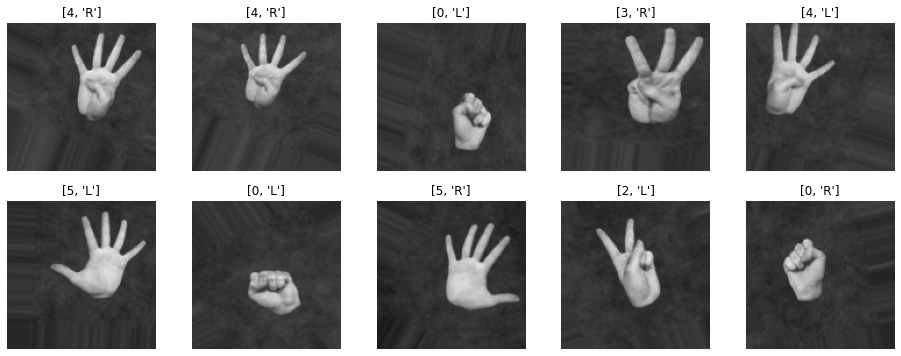

In [9]:
#reverse class indices
def target_label(x):
    reverse_class_indices = dict((value, key) for (key, value) in train_generator.class_indices.items())
    fingers = reverse_class_indices[np.argmax(x[:6])]
    hand = reverse_class_indices[6+np.argmax(x[-2:])]
    return [int(fingers), hand]

#training images
plt.figure(figsize=(16,6))
for image, label in train_generator:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image[i])
        plt.axis('off')
        plt.title(target_label(label[i]))
        #print(label[i])
    break

In [11]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

x = tf.keras.layers.Flatten()( pretrained_model.output )
x = tf.keras.layers.Dropout(0.5)( x )
x = tf.keras.layers.Dense(512, activation='relu')( x )
output = tf.keras.layers.Dense(8, activation='sigmoid')( x )

model = tf.keras.models.Model( pretrained_model.input , output )

pretrained_model.trainable = False

model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [12]:
def get_image_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.mobilenet_v2.preprocess_input(array)
    return array

In [13]:
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
check_point = keras.callbacks.ModelCheckpoint(filepath='counting_4.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_generator,
epochs=10,
validation_data=valid_generator,
callbacks=[check_point],
)

In [15]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (128,128)

# Remove last layer's softmax
model.layers[-1].activation = None

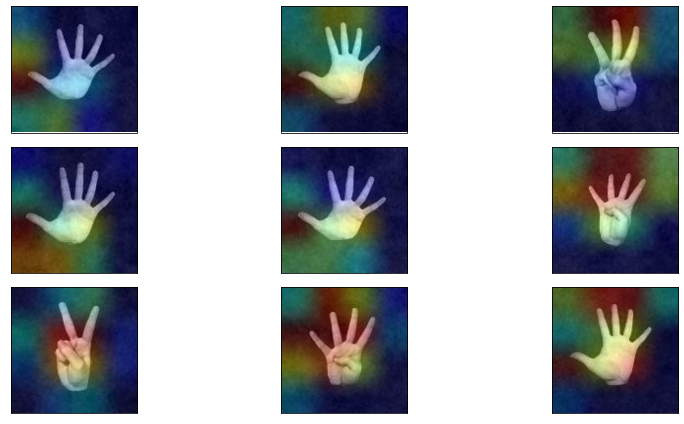

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = os.path.join(test_dir, df_test.loc[i, 'image']).replace('\\', '/')
    img_array = preprocess_input(get_img_array(img_path, size=(128,128)))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    #ax.set_title(f"True: {df_test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [18]:
#validation images
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='image',
    y_col='labels',
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=False,
    seed=4,
    subset='validation'
)

#predictions on validation set
out = model.predict(validation_generator)
#generating truth labels for validation set in one-hot encoded form
y_test = np.zeros((out.shape[0], 8))
for i, label in enumerate(validation_generator.labels):
    y_test[i, label] = 1

#threshold for classification
threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append(matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

#threshold for classification
print('best threshold for classification: {}'.format(best_threshold))

y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])
print('hamming loss on validation set: {}'.format(hamming_loss(y_test,y_pred)))

Found 3600 validated image filenames belonging to 8 classes.
225/225 [==============================] - 13s 52ms/step
best threshold for classification: [0.1 0.1 0.4 0.8 0.1 0.1 0.1 0.3]
hamming loss on validation set: 0.050486111111111114


In [20]:
#test images
test_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_dir,
    x_col='image',
    y_col='labels',
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=False,
    seed=4,
)

#test set predictions
out = model.predict(test_generator)
#one-hot encoding
y_test = np.zeros((out.shape[0], 8))
for i, label in enumerate(test_generator.labels):
    y_test[i, label] = 1

#predictions after applying tresholds
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])
print('hamming loss on test set: {}'.format(hamming_loss(y_test,y_pred)))

Found 3600 validated image filenames belonging to 8 classes.
225/225 [==============================] - 13s 58ms/step
hamming loss on test set: 0.05
